Currently testing: MMD

In [3]:
from __future__ import print_function
import numpy as np
import scipy.sparse as sp
import scipy

# saving/loading simulated data
import pickle as pk

# Dougal code imports
from skl_groups.features import Features
from sklearn.pipeline import Pipeline
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.kernels import PairwisePicker, Symmetrize, RBFize, ProjectPSD
import mmd  # conda install -c dougal mmd
from sklearn.metrics.pairwise import euclidean_distances

# for post-kernel generation analysis
from sklearn import manifold
from sklearn.manifold import LocallyLinearEmbedding
import seaborn as sns
from mpl_toolkits.axes_grid1 import *


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def saveSimilarities(fn, sims):
    """
    Save the similarity matrix to a .npz file.

    Inputs:
    - fn: directory/filename to save the file to (extension will be provided by func.)
    - sims: similarity matrix

    Returns: nothing
    """
    np.savez(fn, similarities=sims)
    print("Saved the similarities to a file.")

def loadSimilarities(fn):
    """
    Load the previously saved similarity matrix from a .npz file

    Inputs:
    - fn: directory/filename (minus extension) to load the file from

    Returns:
    - loadedSims: similarity matrix
    """
    loader = np.load(fn+".npz")
    print("Similarities loaded!")
    return loader['similarities']

def loadSimFeats(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - features: single patient's features/nodes
    - ids: subject ids
    - y: the label (number of abnormal nodes)
    """
    with open(fn+"-feats.data.p", "rb") as f:
        loader = pk.load(f)
    f.close()
    print("Simluated patient features and metadata loaded!")
    return loader['ids'], np.asarray(loader['y']), loader['features']

In [7]:
# generate kernel
# load the patient node information
patientsFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/simulatedSubjects"
# patientsFN = "/pylon2/ms4s88p/jms565/projects/MNISTSubjects/simulatedSubjects"
subjIds, numAbnormalNodes, loadedSubjs = loadSimFeats(patientsFN)

Simluated patient features and metadata loaded!


In [8]:
print(len(loadedSubjs))
print(len(loadedSubjs[0]))
print(len(loadedSubjs[0][0]))
print(loadedSubjs[0][0])

2000
400
20
[ 0.1134332   0.04674781  2.61323862  0.09648364  4.37398769  2.52762957
  0.29463625  2.91719764  4.41590622  0.225878    0.08748444  0.30162318
  3.0396272   0.11061031  2.09783291  5.22556808  0.08470466  0.27307057
  0.21872002  2.50622394]


In [9]:
# testing MMD pairwise similarities before putting it in a function
patients = loadedSubjs
y = numAbnormalNodes
sub = np.vstack(np.asarray(patients))
print(sub.shape)

(800000, 20)


In [31]:
# median of a subset of a space will be approximately the 
# same as the median of the original space - saves time
sub = sub[np.random.choice(sub.shape[0], min(1000, sub.shape[0]), replace=False)]
print(sub.shape)
# get the squared euclidean distance
D2 = euclidean_distances(sub, squared=True)
# now use the squared euclidean distance to calculate the median squared
med_2 = np.median(D2[np.triu_indices_from(D2, k=1)], overwrite_input=True)
print(med_2)

# now Dougal has something with gamma multipliers... 
# what should I use for gamma? Before we used 1. This time I'm trying different values
gammas = [0.25, 0.5, 1, 2, 4]
# gammas = 1
gamma1 = np.divide(gammas, med_2)
print(gamma1)

(1000, 20)
254.916580768
[ 0.00098071  0.00196143  0.00392285  0.0078457   0.01569141]


In [32]:
# calculate the MMD^2
mmds, mmk_diags = mmd.rbf_mmd(patients, gammas=gamma1, squared=True, n_jobs=8, ret_X_diag=True)
print("Type(mmd):", type(mmds))
print(mmds.shape)

Type(mmd): <type 'numpy.ndarray'>
(5, 2000, 2000)


In [37]:
#     sims = np.empty((len(gammas), len(gammas), len(y), len(y)))
gamma2 = gammas
sims = np.empty((len(gamma2), len(gamma1), len(patients), len(patients)))
print(type(sims))
print(sims.shape)
print(mmds.shape)

<type 'numpy.ndarray'>
(5, 5, 2000, 2000)
(5, 2000, 2000)


In [39]:
for i in xrange(len(gamma1)):
    D2_mmd = mmds[i]
    med2 = np.median(D2_mmd[np.triu_indices_from(D2_mmd, k=1)])
    print(med2)
    gamma2 = gammas/med2
    
    # iterate through the gamma2
    for j in xrange(len(gamma2)):
        sims[j, i, :, :] = np.exp(np.multiply(D2_mmd, -gamma2[j]))

# return sims

0.0156568271301
0.0258624832249
0.0367280113362
0.0421834971214
0.0384289438425


In [190]:
def computePairwiseSimilaritiesMMD(patients, y):
    """
    Compute the pairwise similarity between bags using Dougal's MMD module

    Inputs:
    - patients: the collection of patient features
    - y: labels (number of abnormal nodes) for each subject. May not be used.

    Returns:
    - sims: the mmd pairwise similarities between each patient
    * Note: sims is a NxN symmetric matrix, where N is the number of subjects
    """
    sub = np.vstack(np.asarray(patients))
    print(sub.shape)
    # median of a subset of a space will be approximately the 
    # same as the median of the original space - saves time
    sub = sub[np.random.choice(sub.shape[0], min(1000, sub.shape[0]), replace=False)]
    print(sub.shape)
    # get the squared euclidean distance
    D2 = euclidean_distances(sub, squared=True)
    # now use the squared euclidean distance to calculate the median squared
    med_2 = np.median(D2[np.triu_indices_from(D2, k=1)], overwrite_input=True)
    print(med_2)
    
    # now Dougal has something with gamma multipliers... 
    # what should I use for gamma? Before we used 1.
    gammas = [0.25, 0.5, 1, 2, 4]
#     gammas = 1
    gamma1 = gammas/med_2
    
    
    # calculate the MMD^2
    mmds, mmk_diags = mmd.rbf_mmd(patients, gammas=gamma1, squared=True, n_jobs=8, ret_X_diag=True)
    print("Type(mmd):", type(mmds))
    print(mmds.shape)
    
    gamma2 = gammas
    sims = np.empty((len(gamma2), len(gamma1), len(patients), len(patients)))
    print(type(sims))
    print(sims.shape)
    print(mmds.shape)
    
    for i in xrange(len(gamma1)):
        D2_mmd = mmds[i]
        med2 = np.median(D2_mmd[np.triu_indices_from(D2_mmd, k=1)])
        print(med2)
        gamma2 = gammas/med2

        # iterate through the gamma2
        for j in xrange(len(gamma2)):
            sims[j, i, :, :] = np.exp(np.multiply(D2_mmd, -gamma2[j]))

    # return sims

In [191]:
# Compute the pairwise similarity between patients using Dougal code
print("Calculating similarities...")
sims = computePairwiseSimilaritiesMMD(loadedSubjs, numAbnormalNodes)
print("Similarities calculated!")

Calculating similarities...
(800000, 20)
(1000, 20)
262.809463232
Type(mmd): <type 'numpy.ndarray'>
0.0362750289135


TypeError: object of type 'int' has no len()

In [45]:
print("Divergence matrix:", sims.shape)
print("Min value of divergence matrix:", sims.min())
print("Max value of divergence matrix:", sims.max())
print("Looking at some values on the diagonal:", sims[0][0][0][0], sims[0][0][1][1], sims[0][0][2][2])

print("\nSome of the measured divergences are symmetric:\n (sims==sims.T).any()",(sims[0][0] == sims[0][0].T).any())
print("...and all of them are:\n (sims==sims.T).all()", (sims[0][0]==sims[0][0].T).all())

Divergence matrix: (5, 5, 2000, 2000)
Min value of divergence matrix: 3.57006122918e-25
Max value of divergence matrix: 1.0
Looking at some values on the diagonal: 1.0 1.0 1.0

Some of the measured divergences are symmetric:
 (sims==sims.T).any() True
...and all of them are:
 (sims==sims.T).all() True



Trying some plotting things...


<function matplotlib.pyplot.colorbar>

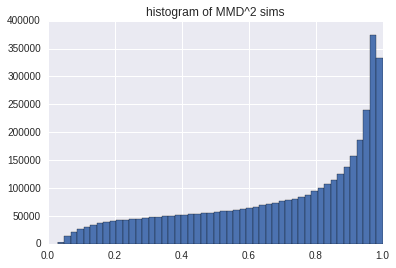

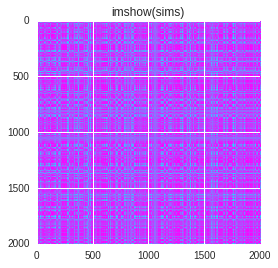

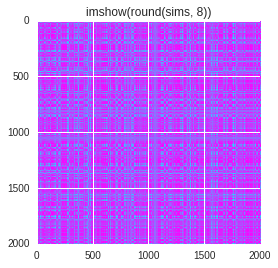

In [47]:
print("\nTrying some plotting things...")
_ = plt.hist(sims[0][0].flatten(), 50)
plt.title("histogram of MMD^2 sims")

plt.figure()
plt.imshow(sims[0][0], vmin=0.0, vmax=1.0, cmap="cool")
plt.title("imshow(sims)")
plt.colorbar

plt.figure()
plt.imshow(np.round(sims[0][0], 8), vmin=0.0, vmax=1.0, cmap="cool")
plt.title("imshow(round(sims, 8))")
plt.colorbar

In [51]:
# Save the similarities
kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-matrix-mmd"
saveSimilarities(kernelFN, sims)
# Load the similarities to test
loadedKernel = loadSimilarities(kernelFN)
assert (loadedKernel==sims).all()

Saved the similarities to a file.
Similarities loaded!


## Now trying to incorporate kernel analysis

In [53]:
def  plotLowDimWithColor( nodes2D, subjColor, 
                         ax=None, plotTitle=None, markerSize=2 ):
    """
    plot low dimensional embedding
    
    Inputs:
    - nodes2D: subset of patients that came from a higher dimensional space and need to be plotted in 2D for visualization
    - subjColor: number of abnormal nodes in each simulated patient
    
    Returns: nothing
    Effect: plots a scatter plot
    """
    inFeature = nodes2D

    # normalize the colors to a good range
    maxVal = -np.sort(-np.asarray(subjColor))[0]
    minVal = np.sort(np.asarray(subjColor))[0]
    cm = plt.cm.get_cmap('RdYlBu_r')
    #print(subjColor)
    
    if ax==None:
        scatter(inFeature[:,0], inFeature[:,1], c=subjColor, 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize )
        colorbar()
        plt.xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        plt.ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0))   
        plt.title(plotTitle)      
    else:
        scPlot = ax.scatter(inFeature[:,0], inFeature[:,1], c=np.asarray(subjColor), 
                lw = 0, vmin=minVal, vmax=maxVal,  
                cmap=cm, s=markerSize  )
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scPlot, cax=cax)
        ax.set_xlim(np.percentile(inFeature[:,0], 1, axis=0), 
                 np.percentile(inFeature[:,0], 99, axis=0))
        ax.set_ylim(np.percentile(inFeature[:,1], 1, axis=0), 
                 np.percentile(inFeature[:,1], 99, axis=0)) 
        ax.set_title(plotTitle)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

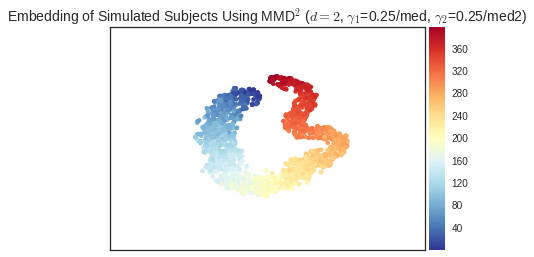

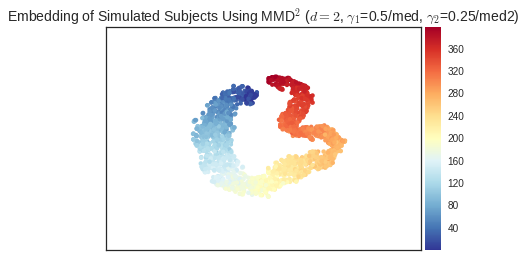

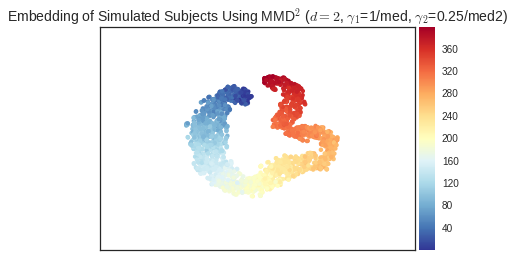

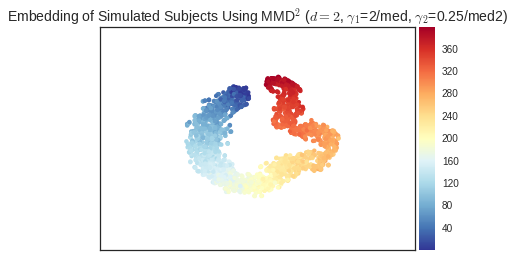

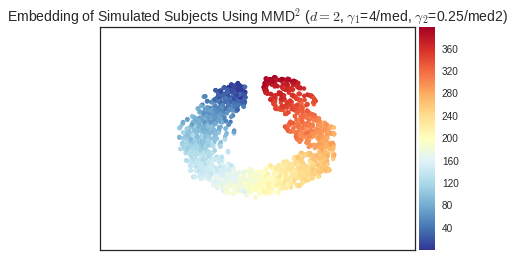

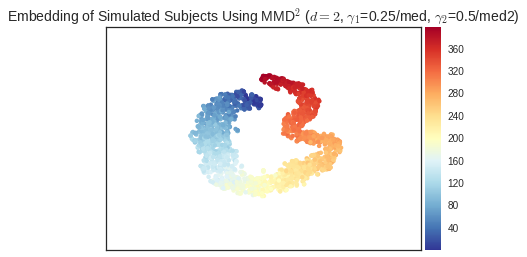

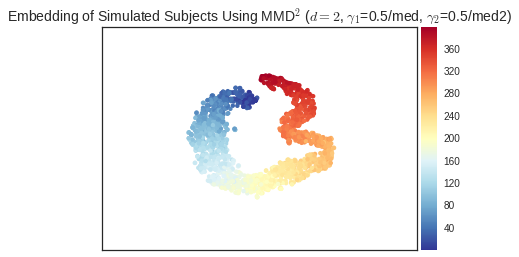

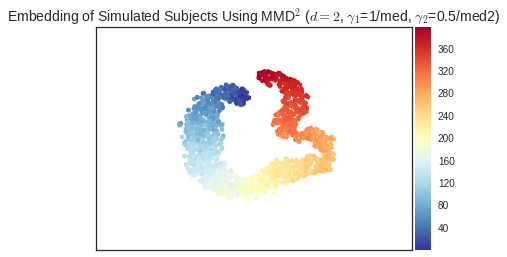

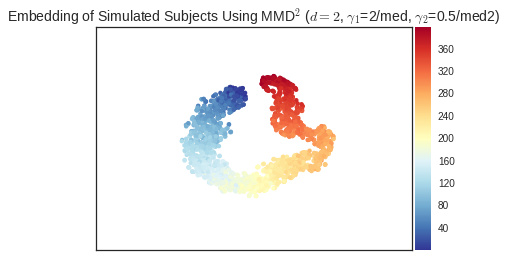

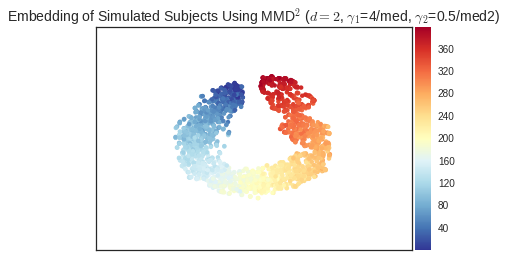

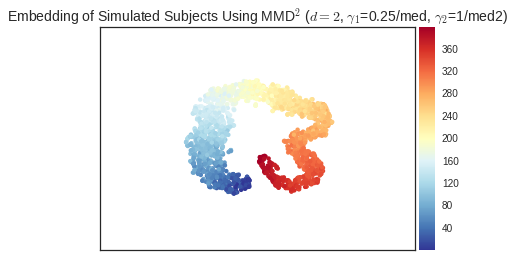

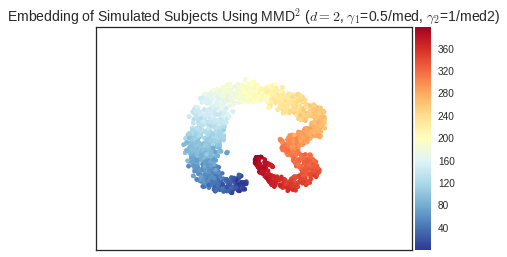

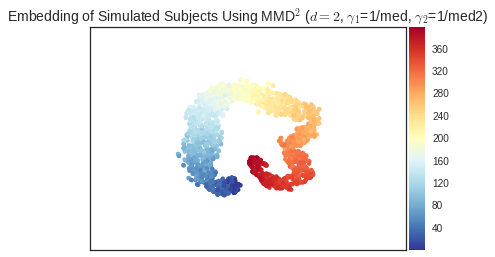

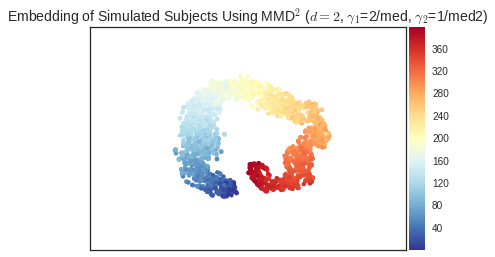

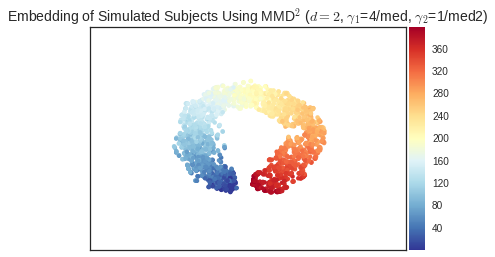

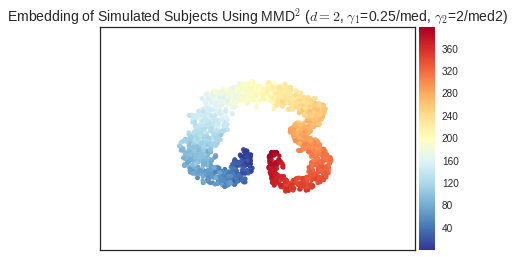

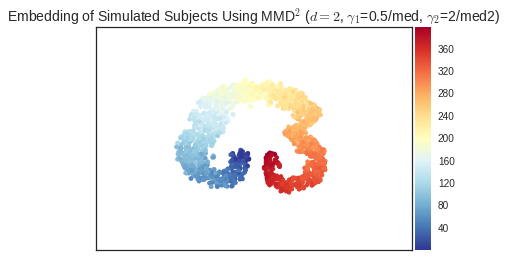

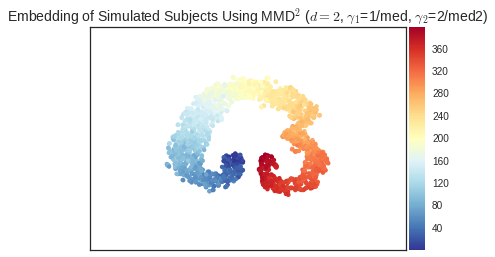

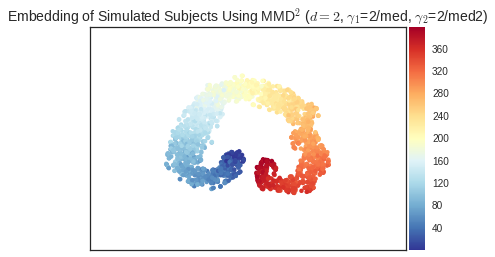

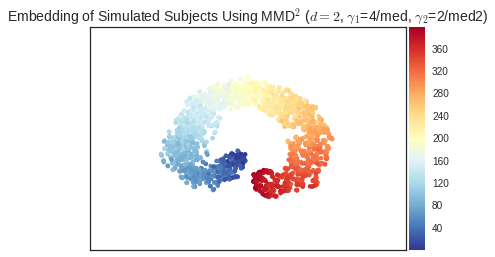

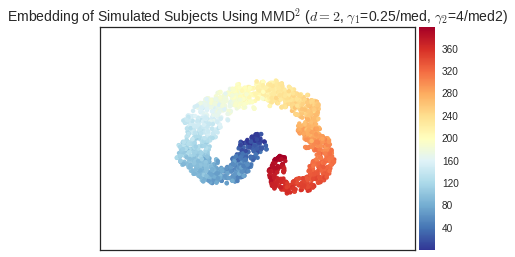

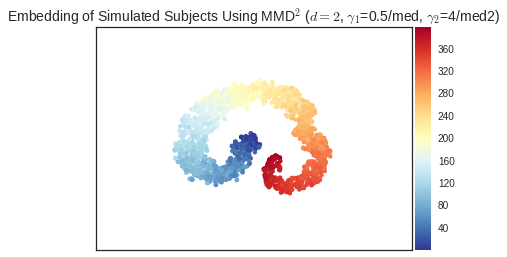

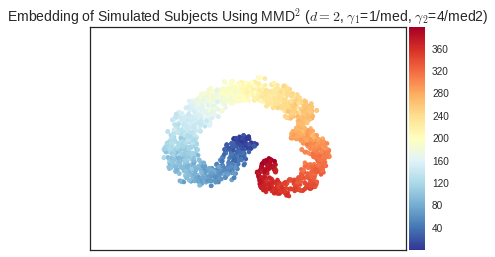

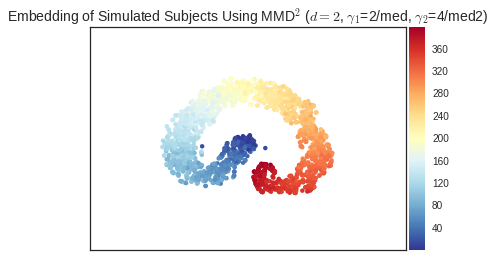

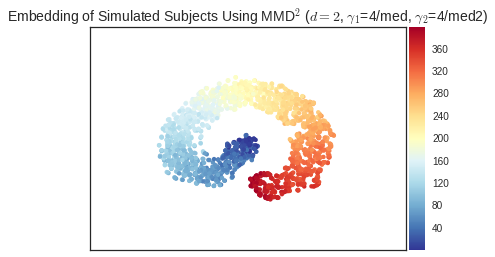

In [76]:
# ensure PSD
regParam = 1e-3
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
# setup for plotting
permIdx = np.random.permutation(range(len(subjIds)))
N = 2000
            
for j in xrange(len(sims)): # iterate through gamma2
    for i in xrange(len(sims[0])): # iterate through gamma1
        f = plt.figure((j+1)*5+(i+1))
        # cholesky factorization: sigma*sigma^-1
        hidimMMD = np.linalg.cholesky(sims[j][i]+(regParam*np.eye(sims[j][i].shape[0])))

        # TSNE embedding into 2D for scatterplot (visualize structure in low-dim space)
        tSNEMMD = tsne.fit_transform(hidimMMD)

        # plotting the scatterplot
        with sns.axes_style("white"):
            f, ax1 = plt.subplots()
        # each subject is a dot in 2D, the color corresponds to y
        tSNEMMD_subset = tSNEMMD[permIdx[:N]]
        subjClasses_subset = numAbnormalNodes[permIdx[:N]]
        plotLowDimWithColor(tSNEMMD_subset, subjClasses_subset, ax=ax1, plotTitle='tSNE', markerSize=20)

        ax1.set_xlim([-30,30])
        ax1.set_ylim([-30,30])
        t = str.format("Embedding of Simulated Subjects Using MMD$^2$ ($d=2$, $\gamma_1$={0}/med, $\gamma_2$={1}/med2)", gammas[i], gammas[j])
        ax1.set_title(t, fontsize=14)

        fn = str.format("/home/jms565/Research/COPDImageAnalysis/figures/tsne-mmd-gamma1-{0}-med-gamma2-{1}-med2.pdf", gammas[i], gammas[j])
        f.savefig(fn, bbox_inches='tight')

## Proceding using both gammas = 1/med

In [95]:
# Select the set of mmds for gammas = 1/med, 1/med
print(gammas[2])
mmds = sims[2][2]
print(mmds.shape)
print((mmds==mmds.T).all())
# Need to symmetrize
sym = Symmetrize()
mmds_sym = sym.fit_transform(mmds)
assert(mmds_sym==mmds_sym.T).all()

1
(2000, 2000)
False


In [97]:
# Save the selected mmds
# Save the similarities
kernelFN = "/home/jms565/Research/COPDImageAnalysis/simulatedData/kernel-matrix-mmd-gammas-1-med"
saveSimilarities(kernelFN, mmds_sym)
# Load the similarities to test
loadedKernel = loadSimilarities(kernelFN)
assert (loadedKernel==mmds_sym).all()

Saved the similarities to a file.
Similarities loaded!


In [85]:
# cholesky factorization: sigma*sigma^-1
hidimMMD = np.linalg.cholesky(mmds+(regParam*np.eye(mmds.shape[0])))
# TSNE embedding into 2D for scatterplot (visualize structure in low-dim space)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tSNEMMD = tsne.fit_transform(hidimMMD)

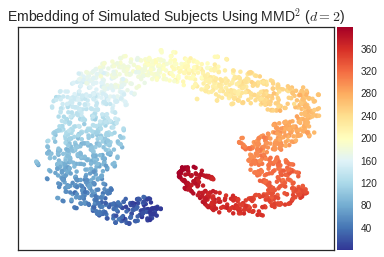

In [101]:
# plotting the scatterplot
with sns.axes_style("white"):
    f, ax1 = plt.subplots()

# each subject is a dot in 2D, the color corresponds to y
permIdx = np.random.permutation(range(len(subjIds)))
N = 2000
tSNEMMD_subset = tSNEMMD[permIdx[:N]]
subjClasses_subset = numAbnormalNodes[permIdx[:N]]
plotLowDimWithColor(tSNEMMD_subset, subjClasses_subset, ax=ax1, plotTitle='tSNE', markerSize=20)

ax1.set_xlim([-15,15])
ax1.set_ylim([-20,20])
ax1.set_title('Embedding of Simulated Subjects Using MMD$^2$ ($d=2$)',fontsize=14)

f.savefig("tsne-mmd-presentable-gammas-1-med.pdf", bbox_inches='tight')

## Continuing the workflow... (LLE next)

In [88]:
# extracting higher dimensional features: D=100
clf = LocallyLinearEmbedding(n_components=100)
LLE_modified_MMD = clf.fit_transform(hidimMMD)
print(LLE_modified_MMD.shape)

(2000, 100)


In [ ]:
# Should probably load the 

In [157]:
# Regression
numPCA_comp = 60
colNameList = []
for numDim in range(2,numPCA_comp,4):
    colNameList.append(['LLE_modified_f%d'%i for i in range(numDim)])

score_r2DictList = {}
p_r2DictList = {}
accScoreDictList = {}
p_accDictList = {}    
    
featureName = 'histFHOG_largeRange_setting1'
score_r2DictList[featureName] = []
p_r2DictList[featureName] = []
accScoreDictList[featureName] = []
p_accDictList[featureName] = []

print(len(colNameList))

15


In [158]:
# Helper functions
def evalFeatures_Regression(XTrain,yTrain,XTest,yTest,m):
    """
    evaluate a regression model
    """

    # scaling
    stdScaler = StandardScaler()
    stdScaler.fit(XTrain)
    XTrain = stdScaler.transform(XTrain)
    yTrain = np.log10(yTrain)
    XTest = stdScaler.transform(XTest)
    yTest = np.log10(yTest)
        
    m.fit(XTrain, yTrain)
    pred_y = m.predict(XTest)
    r2 = metrics.r2_score(yTest, pred_y)
    s = metrics.mean_squared_error(yTest, pred_y)
    return r2, s, pred_y

def loadSimImg(fn):
    """
    Load a previously saved simulated subject from a .npz file.

    Inputs:
    - fn: filename/directory to load from (extensionless)

    Returns:
    - images: single patient's features/nodes
    """
    loader = np.load(fn+".npz")
#     print "Image " + fn + " loaded!"
    return loader['image']

In [159]:
# Do I need this?
N = 2000
imgRoot = "./simulatedData/simulatedImages/S"
# imgRoot = "/pylon1/ms4s88p/jms565/simulatedData/simulatedImages/S"
subjFeatures = [loadSimImg(imgRoot+str(i).zfill(4)) for i in xrange(N)]

IOError: [Errno 2] No such file or directory: './simulatedData/simulatedImages/S0000.npz'

In [ ]:
for colName in colNameList:
    #---------------------  Compute BOW
    t0 = time.clock()
    print "computing bag of words ......"
    feats = Features(subjFeatures)      # here the data is your patient patch data - list of patch features
    bow = BagOfWords(KMeans(n_clusters=len(colName), max_iter=100, n_init=2))
    bowized = bow.fit_transform(feats)
    print "Bag of words computed!"
    print time.time() - t0
    
#     X_KL = LLE_modified_KL[:,:len(colName)]
#     X_HE = LLE_modified_HE[:,:len(colName)]
    X_MMD = LLE_modified_MMD[:,:,len(colName)]
    
    print "Shape of bow: " + str(bowized.shape)
    print "Column name: " + str(colName)
    print "Len(colName): " + str(len(colName))
    print "X.shape: " + str(X_MMD.shape)
    print "len(subjFeatures): " + str(len(subjFeatures))
    print "len(subjFeatures[0]): " + str(len(subjFeatures[0]))
    print "len(subjFeatures[0][0]): " + str(len(subjFeatures[0][0]))

    # make a cross-validation object
    cv = KFold(n=len(subjClasses), n_folds=50, shuffle=False, random_state=0)

    ### regression
    allXy = {}    
    yName = 'FEV1pp_utah'    

    
#     allXy['SimulatedNNFeats'] = (X,y)
#     allXy['BOW'] = (bowized,y)
    y = np.asarray(subjClasses)  # loaded earlier as the number of abnormal nodes in the subject
#     allXy['Ours-KL'] = (X_KL, y)   # lle_modified
#     allXy['Ours-HE'] = (X_HE, y)
#     allXy['BOW'] = (bowized, y)    # replaced y with subjList
    allXy['Ours-MMD'] = (X_MMD, y)

    score_r2Dict = {}
    p_r2Dict = {}
    for k in allXy.keys():         
        #clf = linear_model.Ridge(alpha=1)
        score_r2Dict[k] = [] 
        #score_r2Dict[k] = cross_val_score(clf, allXy[k][0], allXy[k][1], cv=50, scoring='r2_score')
        print "working on ",k, "...."
        for i, (train, test) in enumerate(cv):
            clf = linear_model.Ridge(alpha=1)
            r2,s,pred = evalFeatures_Regression(allXy[k][0][train],    # your X (LLE_modified)
                                           allXy[k][1][train],    # your y 
                                           allXy[k][0][test],     # your X
                                           allXy[k][1][test],clf) # your y
            score_r2Dict[k].append(r2)

    # add the results to a list
    score_r2DictList[featureName].append(score_r2Dict)
#     p_r2DictList[featureName].append(p_r2Dict)
#     accScoreDictList[featureName].append(accScoreDict)
#     p_accDictList[featureName].append(p_accDict)
    

resultsRoot = './simulatedData/evaluation'
pk.dump( score_r2DictList, open(resultsRoot + "/regression_MMD.p",'wb') )
# pk.dump( p_r2DictList, open(resultsRoot + "/linReg_p_r2DictList.p",'wb') )
# pk.dump( accScoreDictList, open(hellingerRoot + "/linReg_accScoreDictList.p",'wb') )
# pk.dump( p_accDictList, open(hellingerRoot + "/linReg_p_accDictList.p",'wb') )